
# Accelerating Monte Carlo

Here we summarize the most relevant results achieved during the project. We provide a brief description of the theretical framework, as the code and the plots in order to be as clear as possible.


## Theory

-----



### Model



$$
H(\mathbf{\sigma}) = \sum_{i=1}^{N} J_{ij}\sigma_i\sigma_j
$$
with the couplings strength between spin $i$ and $j$ $J_{ij}\in[-1,1]$ uniformly distributed and $\sigma_i \in \{\pm1\}$. $\mathbf{\sigma} = (\sigma_1, \dots, \sigma_N)$ indicates the spin configuration.
We compute are interested in the thermodinamic properties such as the average energy $E=\langle H(\mathbf{\sigma})\rangle$ or the magnetization $m=\langle \sum_{i=1}^N{\sigma_i} \rangle$, where the brackets indicate the expectation value over the Boltzmann distribution
$$
P(\mathbf{\sigma}) = \exp{[-\beta H(\mathbf{\sigma})]} / Z, 
$$ 
where $\beta=1/k_BT$ is the inverse temperature, $k_B=1$ the Boltzmann constant, T the temperature and $Z=\sum_{\mathbf{\sigma}}{\exp{[-\beta H(\mathbf{\sigma})]}}$ is the partition function.


### Method



The properties defined above can be computed with a stochastic Markov Chain in the configuration space, driven by by a suitable transition matrix. Each entry of the matrix $T_{\mathbf{\sigma'}\mathbf{\sigma}}$ represent the probability to move from the configuration $\mathbf{\sigma'}$ to $\mathbf{\sigma}$, thus must apply the *datailed balance condition* $T_{\mathbf{\sigma'}\mathbf{\sigma}} \geq 0$ and $\sum_{\mathbf{\sigma'}}{T_{\mathbf{\sigma'}\mathbf{\sigma}}} = 1$ for any $\mathbf{\sigma}$. A common procedure is to decompose $T_{\mathbf{\sigma'}\mathbf{\sigma}} = \omega_{\mathbf{\sigma'}\mathbf{\sigma}}A_{\mathbf{\sigma'}\mathbf{\sigma}}$ for $\mathbf{\sigma'} \neq \mathbf{\sigma}$, where $\omega_{\mathbf{\sigma'}\mathbf{\sigma}}$ is the probability to propose moving from $\mathbf{\sigma}$ to $\mathbf{\sigma'}$ and $A_{\mathbf{\sigma'}\mathbf{\sigma}}$ is the probability to accept the proposed update.

The Metropolis-Hastings algorithm is a way to satisfy the detailed balance condition, where they defined the acceptance probability as 
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')\omega_{\mathbf{\sigma}\mathbf{\sigma}'}}{p(\mathbf{\sigma})\omega_{\mathbf{\sigma}'\mathbf{\sigma}}}\right).
$$
One can consider a symmertic proposal distribution, as in the single spin-flip algorithm where we chose uniformly a spin $i$ and propose to flip it. In that case the acceptance probability involves only the Boltzmann probability $P(\mathbf{\sigma})$, i.e., $A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{P(\mathbf{\sigma}')}{P(\mathbf{\sigma})}\right)$.


#### Autoregressive Neural Network 



As explained in the paragraph above, we can change the proposal distribution, keeping in mind the detailed balance condition. *Machine Learning* (ML) gives us a possible alternative method. in particular a subclass of Neural Networks (NN), the Autoregressive Neural Networks (ANN) that aim to solve the general problem of the *distribution estimation*. The distribution estimation is the task of estimating a joint distribution $p(\mathbf{x})$ from a set of examples $\{\mathbf{x}^{(t)}\}^T_{t=1}$.
The data generation usually is made sampling a latent state $\mathbf{h}$ from some prior $p(\mathbf{h})$, then sampling the observed data $\bf{x}$ from some conditional $p(\mathbf{x} \mid \mathbf{h})$.

So we introduce a particular ANN, called **M**asked **A**utoregressive **D**ensity **E**stimator (**MADE**), that we will use as a proposal generator for the Markov Chain Monte Carlo (MCMC).

Here and in the following, we consider a training set of examples $\left\{\mathbf{x}^{(t)}\right\}_{t=1}^T$ where each input is a $D$-dimensional array $\mathbf{x} = (x_1, \dots, x_D)$ with $x_d \in \{0,1\}$.
The aim of an autoencoder is to obtain an hidden representation $\bf{h(x)}$ of the input $\bf{x}$, and then obtain a reconstruction $\hat{\mathbf{x}}$ as close as possible to $\mathbf{x}$. Thus we have
$$
\mathbf{h}(\mathbf{x}) = \mathbf{g}\left(\mathbf{b} + \mathbf{W}\mathbf{x}\right), \\
\hat{\mathbf{x}} = \sigma\left(\mathbf{c} + \mathbf{V}\mathbf{h}(\mathbf{x})\right),
$$
where $\mathbf{W}$ and $\mathbf{V}$ are matrices, $\mathbf{b}$ and $\mathbf{c}$ are vectors, $g=\text{ReLU}(x)$ and $\sigma(x)=1 / (1 + \exp(-a))$. 
The neural network is train by minimizing the binary cross-entropy loss function
$$
\ell(\mathbf{x})= \sum_{d=1}^D -x_d\log(\hat{x}_d) -(1-x_d)\log(1-\hat{x}_d).
$$
Treating $\hat{x}_d$ as the probability that $x_d$ is 1, i.e., $p(x_d=1)$, the cross-entropy is nothing more than the negative log-likelihood function. The neural network is then trained optimizing the parameters $\left \{\mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c} \right\}$.

We impose then that the output of the NN can be used as a probabilities. We exploit the so called *autoregressive property*, where each dimension of input $\mathbf{x}$ is predicted sequentially. More precisely, we can decompose the probability into the product 
$$
p(\mathbf{x}) = \prod_{d=1}^{D} p(x_d \mid \mathbf{x}_{<d}),
$$
where $\mathbf{x}_{<d} = \left( x_1, x_2, \dots, x_{d-1} \right)$ is a vector with the first $d$ elements of the input. So, assuming $p(x_d = 1 \mid \mathbf{x}_{<d}) = \hat{x}_d$ and thus $p(x_d = 0 \mid \mathbf{x}_{<d}) = 1 - \hat{x}_d$, the cross-entropy loss function becomes a proper negative log-likelihood
$$
-\log p(\mathbf{x}) = \sum_{d=1}^D -\log p(x_d \mid \mathbf{x}_{<d})= \sum_{d=1}^D -x_d\log p(x_d \mid \mathbf{x}_{<d}) - (1-x_d)\log p(x_d \mid \mathbf{x}_{<d}) = \ell(\mathbf{x}).
$$

In order for the NN to satisfy the autoregressive property, one has to *mask* some connections. In fact, to decompose the probability into a product, the output $\hat{x}_d$  has to be independent from the subsequent inputs $\mathbf{x}_{>d} = \left( x_d, \dots, x_D \right)$, thus the weight matrices ($\mathbf{W}$ and $\mathbf{V}$) must have zeros on the connections that we need to remove. Therefore we define two masks $\mathbf{M^W}$ and $\mathbf{M^V}$ for $\mathbf{W}$ and $\mathbf{V}$ such that
$$
\mathbf{h}(\mathbf{x}) = \mathbf{g}\left(\mathbf{b} + \left( \mathbf{W} \cdot \mathbf{M^W}\right) \mathbf{x}\right), \\
\hat{\mathbf{x}} = \sigma\left(\mathbf{c} + \left(\mathbf{V} \cdot \mathbf{M^V}\right) \mathbf{h}(\mathbf{x})\right),
$$
where $\cdot$ indicates the element-wise product.


#### Monte Carlo Algorithms



##### Neural Markov Chain Monte Carlo (N-MCMC) 



We describe here how to use the neural network inside the Monte Carlo algorithm as a smart proposal. We called this procedure *Neural Markov Chain Monte Carlo* (N-MCMC). When using the ANN as a configuration proposal, the Metropolis-Hastings acceptance probability becomes
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')q(\mathbf{\sigma})}{p(\mathbf{\sigma})q(\mathbf{\sigma}')}\right),
$$
where $p$ is the Boltzmann probability without the normalization term $Z$ and $q$ is the probability of the sample computed by the ANN.

The dataset needed to train the **MADE** is generated using the [D-Wave](https://www.dwavesys.com/) quantum system. The D-Wave system is a quantum annealer with up to 5000 qubits. An Ising model can be easily mapped into this kind of annealer to perform adiabatic quantum computation to obtain the ground state of $H$. Since we are in NISQ regime, we cannnot expect the D-Wave annealer to sample *always* the ground state, but it provides low-energy configuration, which can be useful to simulate the low-temperature dinamics.

The algorithm run as follows:

- Generate the dataset with the quantum annealer;
- Train an ANN; 
- Generate new sample using the trained ANN;
- Perform a Monte Carlo using the ANN as a smart proposal.


##### Hybrid Markov Chain Monte Carlo (N-MCMC)


The *pure* neural MCMC can lead some bias in the estimation of the thermodinamics properties, mostly because the dataset itself has bias to the low-energy regime. Thus for instance, the error in energy estimation is greater the higher the temperature. This iussue can be easily solved, since at high temperature regime the classic algorithms such as the single spin-flip Monte Carlo perform quite well. 

So we exploit both the algorithms, neural and single spin flip, to achieve good performance in every regime. We called this procedure *Hybrid Markov Chain Monte Carlo* (H-MCMC) and it runs as follow:

- Generate the dataset with the quantum annealer;
- Train an ANN; 
- Generate new sample using the trained ANN;
- Perform a Monte Carlo:
     - Neural step using the ANN proposal;
     - Classic single spin step.

In our simulation a single spin-flip step is a sweep, i.e., a flip attempt for every spin in the configuration.
The acceptance rate is slightly different, in particular it depends on the type of the next step in the simulation: when the next step is a single spin flip we have
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')}{p(\mathbf{\sigma})}\right),
$$
though if the next step is a neural one we have
$$
A_{\mathbf{\sigma}'\mathbf{\sigma}} = \min\left(1, \frac{p(\mathbf{\sigma}')q(\mathbf{\sigma})}{p(\mathbf{\sigma})q(\mathbf{\sigma}')}\right),
$$ 
where $p$ is the Boltzmann probability without the normalization term $Z$ and $q$ is the probability of the sample computed by the ANN.


## Results

-----


In [1]:
# imports

from typing import Optional, List, Tuple, Union, Any
import json
import os

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

from src.utils.utils import plot_hist, block_std, get_energy
#from src.utils.pltutils import plt_betas_ar
from src.utils.montecarlo import neural_mcmc #hybrid_mcmc, seq_hybrid_mcmc, single_spin_flip

plt.style.use('./images/paper.mplstyle')

In [2]:
# plt function 

def plt_betas_ar(
    acc_rates: List[np.ndarray],
    labels: List[str],
    betas: np.ndarray,
    xlim: Optional[Tuple[float, float]] = None,
    save: bool = False,
):
    fig, ax = plt.subplots() #figsize=(7.2, 6.4), dpi=300

    plt.minorticks_off()


    for i, acc_rate in enumerate(acc_rates):
        plt.plot(betas, acc_rate, "--", label=labels[i])

    if xlim is not None:
        plt.xlim(xlim)

    plt.ylabel(r"$\mathrm{A_r}[\%]$")
    plt.xlabel(
        r"$\mathrm{\beta}$", fontweight="bold"
    )

    plt.legend(loc="best", fancybox=True)

    if save:
        plt.savefig(
            "images/arbeta.png",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            bbox_inches="tight",
        )
        plt.savefig(
            "images/arbeta.eps",
            edgecolor="white",
            facecolor=fig.get_facecolor(),
            # transparent=True,
            bbox_inches="tight",
            format="eps",
        )
    plt.show()
    return


def plt_eng_step(
    eng1: np.ndarray,
    eng2: np.ndarray,
    label1: str,
    label2: str,
    ground_state: Optional[float] = None,
    xlim: Tuple[int, int] = (1, 100000),
    ylim: Optional[Tuple[int, int]] = None,
    title: Optional[str] = None,
    log_scale: bool = True,
    save: bool = False,
):
    fig, ax = plt.subplots()

    if len(eng1.shape) > 1: 
        plt.fill_between(
            np.arange(eng1.shape[-1]) + 1,
            eng1.mean(axis=0) + eng1.std(axis=0),
            eng1.mean(axis=0) - eng1.std(axis=0),
            alpha=0.1,
            color="b",
        )
        plt.plot(np.arange(eng1.shape[-1]) + 1, 
                           eng1.mean(axis=0), label=label1, color="b")
    else:
        plt.plot(np.arange(eng1.shape[-1]) + 1, eng1, label=label1, color="b")

    if len(eng2.shape) > 1:
        plt.fill_between(
            np.arange(eng2.shape[-1] + 1),
            eng2.mean(axis=0) + eng2.std(axis=0),
            eng2.mean(axis=0) - eng2.std(axis=0),
            alpha=0.1,
            color="tab:orange",
        )
        plt.plot(np.arange(eng2.shape[-1]) + 1, eng2.mean(0), "--", 
                           label=label2, color="tab:orange", alpha=0.5, linewidth=1.)
    else:
        plt.plot(np.arange(eng2.shape[-1]) + 1, eng2, "--", 
                label=label2, color="tab:orange", alpha=0.5, linewidth=1.)

    if log_scale:
        ax.set_xscale("log")

    if ground_state is not None:
        plt.hlines(
            ground_state,
            xmin=0,
            xmax=xlim[1] + 100000,
            colors="red",
            linestyles="dashed",
            label="Ground State",
            linewidth=3.0,
        )
        if ylim is None:
            ylim = (ground_state - 0.01, max(eng1.max(), eng2.max()))
            plt.ylim(ylim)
        else:
            plt.ylim(ylim)

    plt.xlim(xlim)

    plt.ylabel(r"$E/N$", fontfamily='serif')
    plt.xlabel(r"$\mathrm{\tau}$")

    if title is not None:
        plt.title(rf"{title}", fontsize=20)

    plt.legend(loc="best", fontsize=18, labelspacing=0.4, borderpad=0.2, fancybox=True)

    if save:
        # TOFIX
        # ERROR: when saving .png
        plt.savefig(
            "images/energy-steps.png",
            facecolor=fig.get_facecolor(),
            bbox_inches="tight",
            transparent=False,
        )
        plt.savefig(
            "images/energy-steps.eps",
            facecolor=fig.get_facecolor(),
            # transparent=True,
            bbox_inches="tight",
            format="eps",
        )
    plt.show()
    return


### Ising model 484 spins and 1NN couplings

Here and in the following we focuse on a fixed size and a particular disordered realization, which we saved in a .txt file.

In [3]:
spin_side = 22
spins = spin_side**2
couplings_path_1nn = "data/couplings/484spins-uniform-1nn.txt"
ground_state_1nn = -0.7550297905


#### Load the data


In [4]:
made_data_1nn = [
"data/generated/sample-1000000_size-484_2022-01-28_15-48-44.npz", # 1mus 1nn
"data/generated/sample-1000000_size-484_2022-01-28_15-50-01.npz", # 10mus 1nn
"data/generated/sample-1000000_size-484_2022-02-10_11-48-45.npz", # 100mus 1nn
"data/generated/sample-1000000_size-484_2022-05-10_23-59-33.npz", # 1-10-100mus 1nn
"data/generated/sample-1000000_size-484_2022-02-10_15-28-37.npz", # 1<beta<2.5 1nn
"data/generated/sample-1000000_size-484_2022-06-07_18-57-46.npz"  # 100mus&1<beta<2.5 1nn
]

In [5]:

parent_path_1nn = "data/hybrid/1nn_100mus_betas10-40/"
hybrid_paths_1nn = sorted(os.listdir(parent_path_1nn))
hybrid_paths_1nn = [parent_path_1nn + path for path in hybrid_paths_1nn]
eng_seq_hybrid_1nn = [np.load(path)['energy'] / spin_side**2 for path in hybrid_paths_1nn]
eng_seq_hybrid_1nn = np.asarray(eng_seq_hybrid_1nn)

In [6]:
# seed for starting point of mcmc simulations
seeds = [12345, 23451, 34512, 45123, 51234]
betas = [2.0, 2.5, 3.0] # we use some significant temperatures only
single_engs_1nn = []
for seed in seeds:
    paths = []
    for beta in betas:
        paths.append(f"1nn-forpaper/484spins-seed{seed}-sample1000000-beta{str(beta)}.npy")
    single_engs_1nn.append(get_energy(22, paths, couplings_path_1nn))
single_engs_1nn = np.asarray(single_engs_1nn)

labels_1nn = [r"1 $\mu$s",r"10 $\mu$s", r"100 $\mu$s", r"1-10-100 $\mu$s", 
          r"$1\leq\beta\leq2.5$", r"$100 \mu$s and $1\leq\beta\leq2.5$"
        ]


#### Acceptance Rate vs $t_A$

Acceptance rate, i.e. $A_{\sigma, \sigma'}$ in the Neural Markov Chain Monte Carlo (N-MCMC) guided by the Autoregressive Neural Network (ANN), at different $\beta$. the ANN is trained using the D-Wave dataset with annealing time $t_A=100 \mu s$.
 

In [ ]:
betas_1nn = np.linspace(0.1, 5, num=50)

acc_rates = []
for i, dataset in enumerate(made_data_1nn):
    acc_rate = []
    if i > 2:
        continue
    for beta in betas_1nn:
        _, eng_neural, ar = neural_mcmc(beta, 100000, dataset, couplings_path_1nn, "made", disable_bar=False)
        acc_rate.append(ar)
    acc_rates.append(acc_rate)

# remove the labels of the dataset  
# that we didn't use
labels_ar = []
for i, label in enumerate(labels_1nn):
    if i>2:
        continue
    labels_ar.append(label)

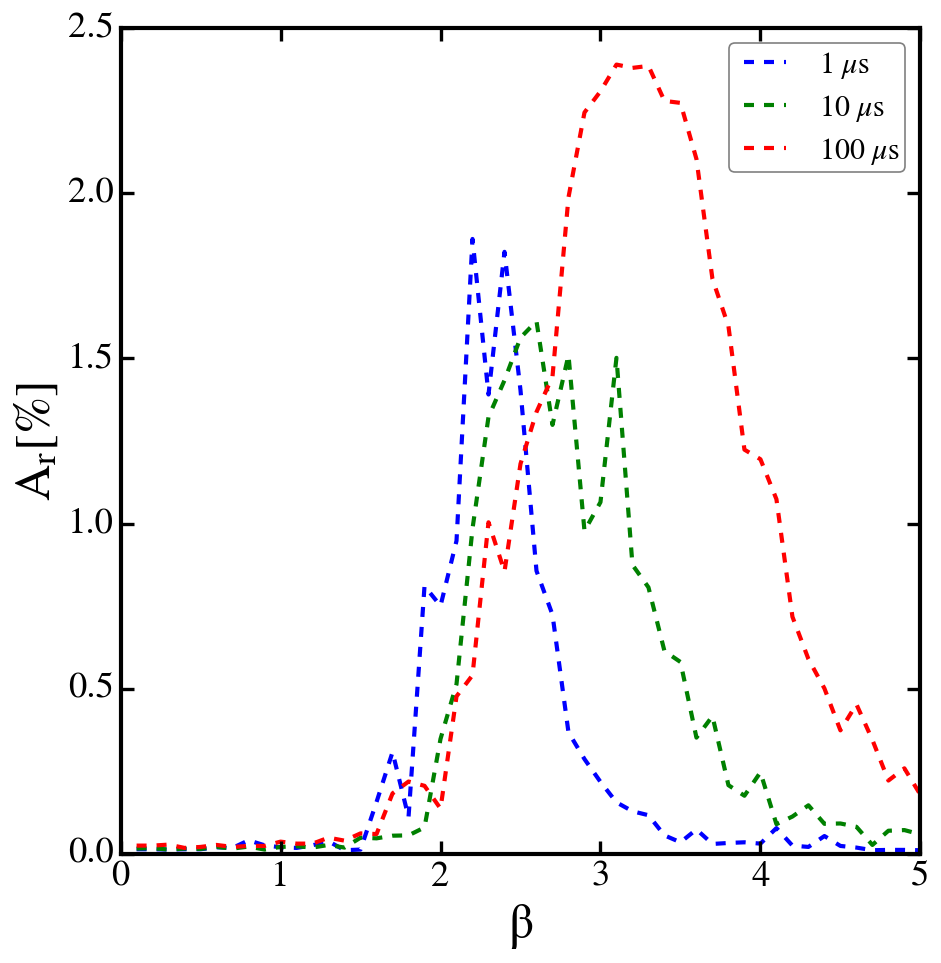

In [110]:
plt_betas_ar(acc_rates, labels_ar, betas_1nn, save=False)


#### Energy vs Steps

Average energy per spin $E/N$ as a function of Monte Carlo steps. The Hybrid Markov Chain Monte Carlo (H-MCMC) thermalizes much faster w.r.t the single spin-flip MCMC. Here for the single spin-flip MCMC we considered a step $\tau$ as a single sweep, for the H-MCMC a step is composed by a sweep and a neural proposal. The horizontal red line is the ground state energy, computed using the McGroundstate solver.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


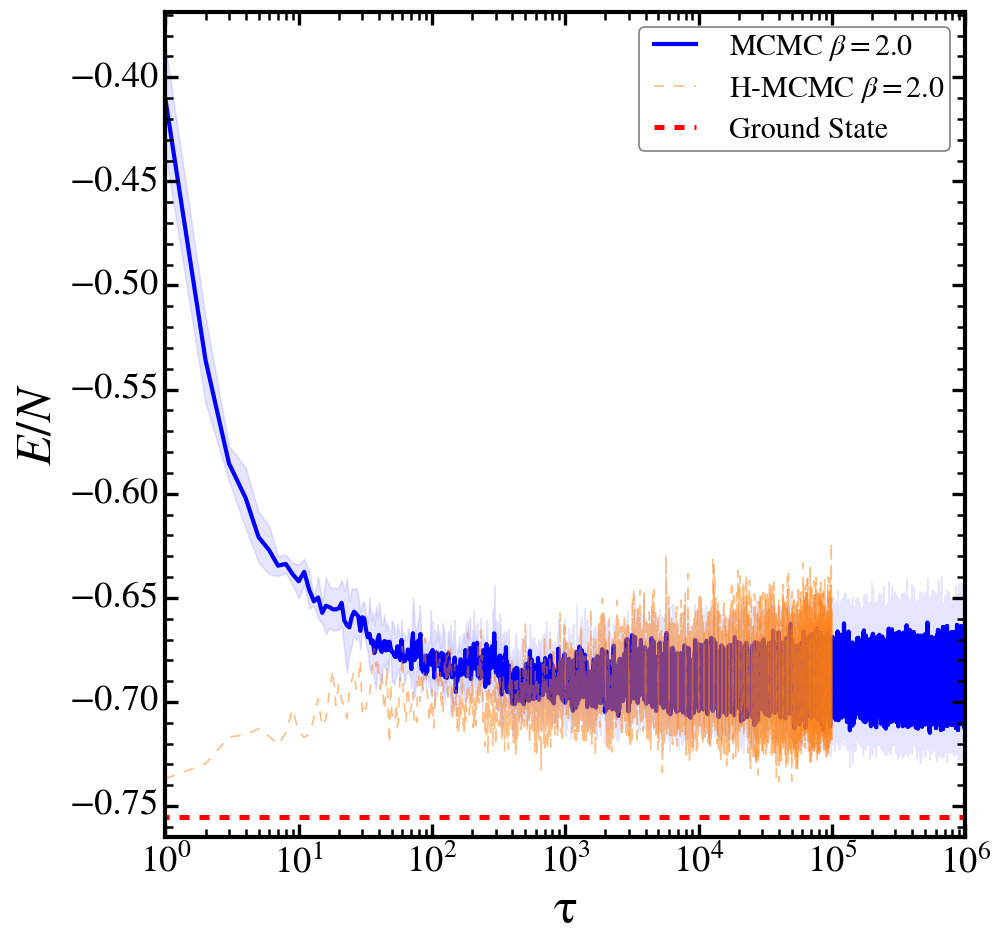

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


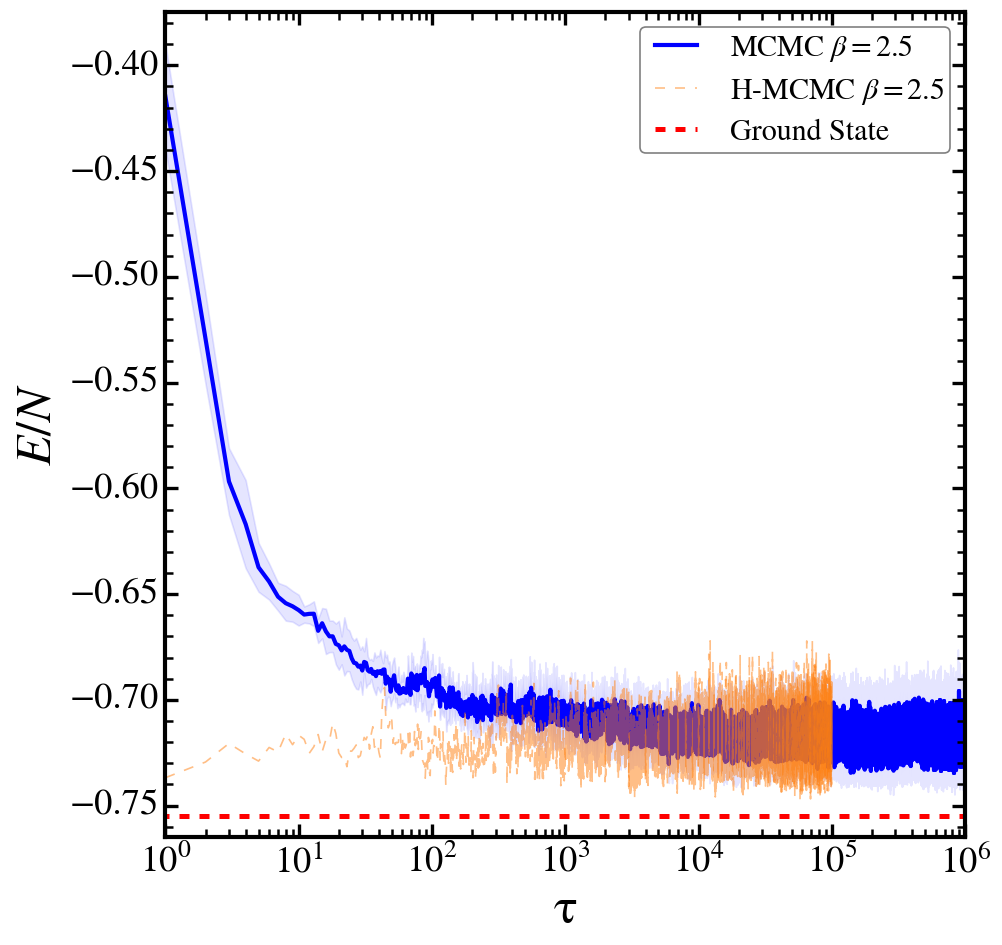

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


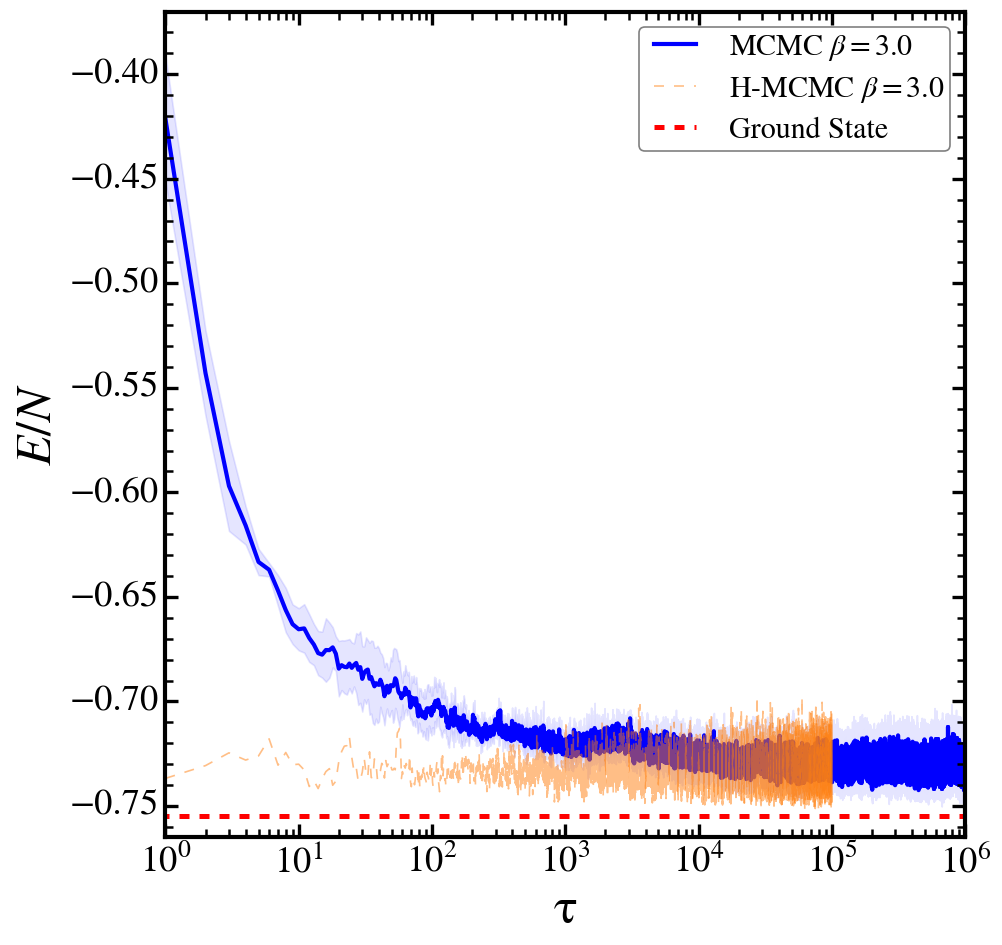

In [7]:
idxs = [10, 15, 20] # valid index in hybrid-MCMC

for i, idx in enumerate(idxs):
    if i!=1:
        pass #continue
    plt_eng_step(single_engs_1nn[:,i], eng_seq_hybrid_1nn[idx, :100000], 
        rf"MCMC $\beta={betas[i]}$", rf"H-MCMC $\beta={betas[i]}$", 
        ground_state=ground_state_1nn, xlim=(1, 1000000), save=True)


#### Autocorrelation vs steps


In [ ]:
skip=100000 #skip the first samples, used for thermalization

ac_betas = []
ac_hybrid = []
for i, idx in enumerate(idxs):
    ac_betas.append(acf(single_engs_1nn[0,i,skip:], nlags=50000, fft=True))
    ac_hybrid.append(acf(eng_seq_hybrid_1nn[idx], nlags=50000, fft=True))

plt_acf_nofit(
    [ac_betas[0], ac_betas[1], ac_betas[2]], 
    [r"MCMC $\beta=2.0$", r"MCMC $\beta=2.5$", r"MCMC $\beta=3.0$"], 
    [ac_hybrid[0], ac_hybrid[1], ac_hybrid[2]], 
    [r"H-MCMC $\beta=2.0$", r"H-MCMC $\beta=2.5$", r"H-MCMC $\beta=3.0$"], 
    ylim=(0.08, 1), 
    xlim=(1, 100000), 
    save=False
)